C:\ProgramData\Anaconda3\envs\B3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\ProgramData\Anaconda3\envs\B3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


using previous tuning parameters
Best OOB Accuracy Estimate during tuning: 0.8414
Best parameters:{'n_estimators': 1000, 'oob_score': True, 'random_state': 123}

Confusion matrix, without normalization
[[526  38]
 [ 75  94]]


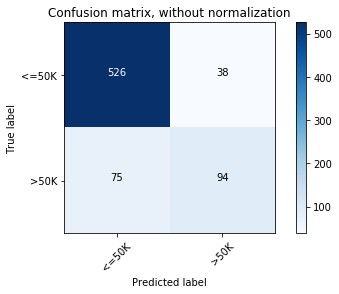

Normalized confusion matrix
[[0.93 0.07]
 [0.44 0.56]]


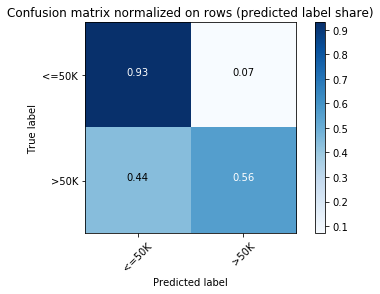

In [1]:
# for notebook plotting
%matplotlib inline 

# load what we need
import time
import timeit
import CHIRPS.structures as strcts
import CHIRPS.datasets as ds
import CHIRPS.datasets_proprietary as dsp
import CHIRPS.routines as rt

import CHIRPS.reproducible as rp
from lore import lore
from lore import test_lore as tlore
from lore import prepare_dataset as prda
from lore import neighbor_generator as ng
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


project_dir = '/datadisk/whiteboxing/examples'
# project_dir = 'V:\\whiteboxing\\examples' # defaults to a directory "whiteboxing" in the working directory
# project_dir = 'C:\\Users\\Crutt\\Documents\\whiteboxing\\exampada'

random_state_splits = 123 # one off for splitting the data into test / train
random_state = 123 # for everything else - e.g. building a new rf with same data

# load one of the included datasets
# project_dir will default to directory name CHIRPS in the working directory if not given
# random_state will default to 123
#mydata = dsp.usoc2(random_state=random_state_splits, project_dir=project_dir)
d_constructor = ds.adult_small_samp
mydata = d_constructor(random_state=random_state_splits, project_dir=project_dir)
meta_data = mydata.get_meta()
name = d_constructor.__name__

meta_data = mydata.get_meta()
save_path = meta_data['get_save_path']()

train_index, test_index = mydata.get_tt_split_idx(random_state=random_state_splits)
# optionally, indexes can be ommitted and will default to scikit's train_test_split method
tt = mydata.tt_split(train_index, test_index)

# lore proprietary
path_data = 'C:\\Users\\id126493\\Documents\\GitHub\\explain_te\\lore\\datasets\\'

# dataset = prepare_german_dataset('german_credit.csv', path_data)
dataset = prda.prepare_adult_dataset('adult.csv', path_data)
# dataset = prda.prepare_compass_dataset('compas-scores-two-years.csv', path_data)

import numpy as np
import pandas as pd
def prepare_dataset_lore(name, ds_container, meta_data):
    # class_col must be at front for this method
    columns = [meta_data['class_col']] + meta_data['features_enc']
    features_type = {k : 'double' for k in meta_data['features_enc']}
    features_type.update({meta_data['class_col'] : 'string'})
    dataset = {
        'name': name,
        'df': pd.DataFrame(ds_container.y_train).merge(pd.DataFrame(ds_container.X_train_enc),
                                                       left_index=True, right_index=True),
        'columns': columns,
        'class_name': meta_data['class_col'],
        'possible_outcomes': meta_data['class_names_label_order'],
        'type_features': {'integer' : [],
                         'double' : meta_data['features_enc'],
                         'string' : [meta_data['class_col']]},
        'features_type': features_type,
        'discrete': [meta_data['class_col']],
        'continuous': meta_data['features_enc'],
        'idx_features': {i : v for i, v in enumerate(meta_data['features_enc'])},
        'label_encoder': meta_data['le_dict'],
        'X': np.array(ds_container.X_train_enc.todense()),
        'y': np.array(ds_container.y_train),
    }

    return dataset

# build model, tuned for high accuracy
model = 'RandomForest'
# model = 'AdaBoost1'
# model = 'AdaBoost2'
# model = 'GBM'

# decide if to run the whole tuning routine again (long for Adaboost)
# RF routine has a default tuning grid, so can leave as None, or come up with some other options
tuning = {'grid' : None, 'override' : False}
if model == 'RandomForest':
    which_trees = 'majority'
    tuning.update({'grid' : None}) # defaults to n_trees [200, 400, ..., 1600]

elif model in ('AdaBoost1', 'AdaBoost2'):
    if model == 'AdaBoost1':
        # classic (and multi-class) AdaBoost
        algo = 'SAMME'
        which_trees = 'majority'
    else:
        algo = 'SAMME.R'
        which_trees = 'conf_weighted'
    max_depth = [i for i in range(1, 5)]
    tuning.update({'grid' : {'base_estimator' : [rt.DecisionTreeClassifier(max_depth=d) for d in max_depth],
                            'n_estimators': [(i + 1) * 200 for i in range(8)], 'algorithm': [algo]}})
    
else: # GBM - not fully implemented yet
    stop # ValueError

rf = rt.forest_prep(ds_container=tt,
                    meta_data=meta_data,
                    # override_tuning=True,
                    model=model,
                    tuning_grid=tuning['grid'],
                    save_path=save_path,
                    plot_cm=True, plot_cm_norm=True)

lore_dataset = prepare_dataset_lore(name, ds_container=tt, meta_data=meta_data)


# X2E = tt.X_test_enc.todense()
# y2E = rf.predict(X2E)
# y2E = np.asarray([dataset['possible_outcomes'][i] for i in y2E])

# idx_record2explain = 0

# explanation, infos = lore.explain(idx_record2explain, X2E, dataset, blackbox=rf,
#                                   ng_function=ng.genetic_neighborhood,
#                                   discrete_use_probabilities=True,
#                                   continuous_function_estimation=False,
#                                   returns_infos=True,
#                                   path=path_data, sep=';', log=False)


In [4]:
tt.X_train

,age,workclass,lfnlwgt,education,educationnum,maritalstatus,occupation,relationship,race,sex,lcapitalgain,lcapitalloss,hoursperweek,nativecountry
676,47,4,12.180950,11,9,2,1,5,4,0,0.000000,0.000000,35,17
1848,48,2,12.580446,11,9,0,3,4,4,1,0.000000,0.000000,40,34
1378,46,2,13.000340,12,14,4,10,1,4,1,0.000000,0.000000,40,34
705,41,2,12.736727,11,9,0,4,1,4,1,0.000000,0.000000,40,34
550,24,2,13.071293,9,13,4,5,1,4,1,0.000000,0.000000,40,34
128,31,2,12.894823,9,13,4,1,1,4,1,0.000000,0.000000,50,34
2299,34,1,12.308173,9,13,4,10,2,2,1,0.000000,0.000000,15,34
2237,56,3,11.791897,15,10,2,4,0,4,1,0.000000,7.422374,40,34
376,19,2,12.478140,15,10,4,1,3,4,0,0.000000,0.000000,10,34
1397,39,3,10.746476,8,11,2,5,0,4,1,0.000000,0.000000,60,34


In [2]:
blackbox = RandomForestClassifier(n_estimators=20)
#blackbox = AdaBoostClassifier(n_estimators=20)

# path_data = '/home/julianhatwell/Documents/github/explain_te/lore/datasets/'



# lore_dataset['possible_outcomes']

tlore.main(dataset=lore_dataset, path_data=path_data, blackbox=blackbox, log=False)


# C:\Users\id126493\Documents\GitHub\explain_te\lore\yadt\dTcmd.exe -fd
# C:\Users\id126493\Documents\GitHub\explain_te\lore\datasets\adult.data -fm
# C:\Users\id126493\Documents\GitHub\explain_te\lore\datasets\adult.names -sep ; -d
# C:\Users\id126493\Documents\GitHub\explain_te\lore\datasets\adult.dot
# b'YaDT version 2.1.0 (c) S. Ruggieri 2002-2018\r\nReading text data\r\n + 
# atts: 12 class: 1 weight: 0 rows: 1031\r\n + 
# load time: 0.00155853 secs (60.69 MiB/s, 661.51 K rows/s)\r\n + 
# indexing ... done\r\n + total time: 0.00194314 secs (48.67 MiB/s, 530.58 K rows/s)\r\nBuilding 1 tree(s) on 1031 cases\r\n +
# tree(s) built\r\n + size: 34 depth: 6 time: 0.00103692 secs\r\nPruning tree using training set\r\n +
# tree pruned\r\n + size: 5 depth: 3 time: 9.31455e-06 secs\r\n'
    
# dataset

{0: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1.

x = {'income': '<=50K', 'workclass_Federal-gov': 0.0, 'workclass_Local-gov': 0.0, 'workclass_Private': 1.0, 'workclass_Self-emp-inc': 0.0, 'workclass_Self-emp-not-inc': 0.0, 'workclass_State-gov': 0.0, 'workclass_Unknown': 0.0, 'workclass_Without-pay': 0.0, 'education_10th': 0.0, 'education_11th': 0.0, 'education_12th': 0.0, 'education_1st-4th': 0.0, 'education_5th-6th': 0.0, 'education_7th-8th': 0.0, 'education_9th': 0.0, 'education_Assoc-acdm': 0.0, 'education_Assoc-voc': 0.0, 'education_Bachelors': 1.0, 'education_Doctorate': 0.0, 'education_HS-grad': 0.0, 'education_Masters': 0.0, 'education_Preschool': 0.0, 'education_Prof-school': 0.0, 'education_Some-college': 0.0, 'maritalstatus_Divorced': 0.0, 'maritalstatus_Married-AF-spouse': 0.0, 'maritalstatus_Married-civ-spouse': 1.0, 'maritalstatus_Married-spouse-absent': 0.0, 'maritalstatus_Never-married': 0.0, 'maritalstatus_Separated': 0.0, 'maritalstatus_Widowed': 0.0, 'occupation_?': 0.0, 'occupation_Adm-clerical': 0.0, 'occupation_

()